<a href="https://colab.research.google.com/github/Jenarth/SCS3250-Group-2-Final-Project/blob/master/3_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **PHASE 3: MACHINE LEARNING**
---

## Linear Regression with Weekdays - Part 1

In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
%matplotlib inline

In [0]:
# Let's import the dataset

url = 'https://raw.githubusercontent.com/Jenarth/SCS3250-Group-2-Final-Project/master/Final%20Dataset.csv'
df = pd.read_csv(url, header = 0, sep =',',parse_dates=['Date'])

In [326]:
df.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [327]:
# Convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df.Weekday = [weekday[item] for item in df.Weekday]
df.head()

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [328]:
# Let's create a new dataset to only select the month of January

jan_df = df[(df.Month == 1)& (df.Year != 2017)]
jan_df.head(2)

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
306,2018-01-01,2018,1,2018-01,1,1,True,-7.9,-18.6,-13.3,-4.383871,-8.916129,0.2,1.929032,-1.729032,0.0,857,366,3844,6347,96,0,131,8728,20369,True,NaN,NaN,NaN
307,2018-01-02,2018,1,2018-01,2,2,False,-7.1,-12.5,-9.8,-4.383871,-5.416129,0.0,1.929032,-1.929032,0.0,7706,10584,20084,25182,12040,4359,6969,74432,161356,True,NaN,NaN,NaN


Let's plot our data points on a graph to eyeball our dataset. We will take a look specifically at Union Station, a central station in Toronto.

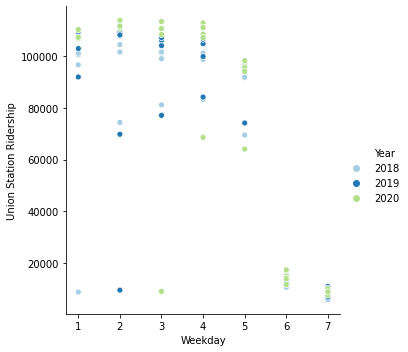

In [329]:
sns.relplot(x='Weekday',y='Union Station Ridership', data=jan_df,hue='Year',palette='Paired')

We notice one outliner by year where there is very little Riderships: the 1st of January.

Let's check our average Riderships for Union Station.

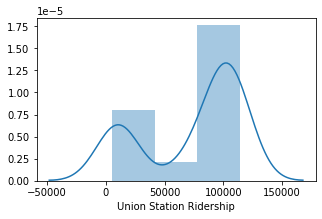

In [330]:
plt.figure(figsize=(5,3))
plt.tight_layout()
sns.distplot(jan_df['Union Station Ridership'])

In [0]:
# Now let's divide the data into attributes ('Weekday') and labels ('Union Station Riderships').

X=jan_df['Weekday'].values.reshape(-1,1)
y=jan_df['Union Station Ridership'].values.reshape(-1,1)

In [0]:
#Split the data to 20% of the data to test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [333]:
# Train the algorithm

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [334]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[133086.70290928]
[[-15336.91472794]]


In [0]:
y_pred = regressor.predict(X_test)

In [336]:
# Let's use our test data and see how accurately our algorithm predicts the percentage score.

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}).round()
df

,Actual,Predicted
0,81222,87076.0
1,104331,87076.0
2,96768,56402.0
3,101709,87076.0
4,9598,25728.0
5,92037,117750.0
6,99938,71739.0
7,109227,102413.0
8,84255,71739.0
9,112993,71739.0


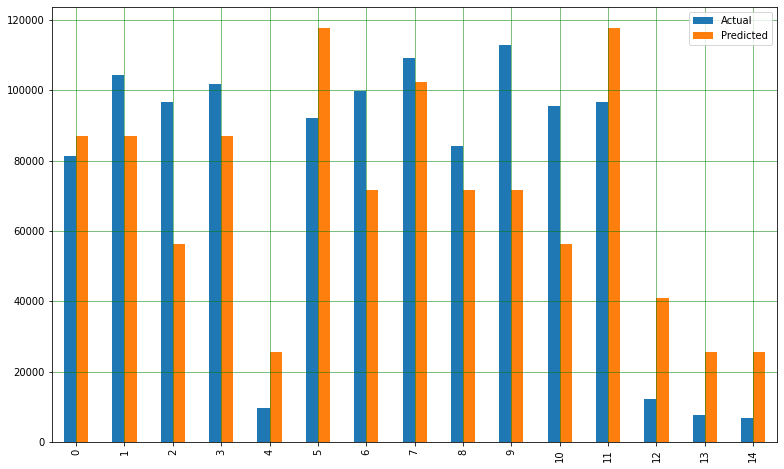

In [337]:
# Let's plot our results 


df1 = df.head(15)
df1.plot(kind='bar',figsize=(13,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Linear Regression with Weekdays - Part 2

In [0]:
df = pd.read_csv(url, header = 0, sep =',',parse_dates=['Date'])

In [339]:
# Let's remove the outliers as well as the holidays period

data= df.loc[(-df.Holiday)&(-df.Outlier)]
data.head(5)

,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [340]:
# Convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
data.Weekday = [weekday[item] for item in data.Weekday]
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Date,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
0,2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
1,2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2,2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
3,2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
4,2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


Let's plot our data points on a graph. Here again will take a look specifically at Union Station, a central station in Toronto.

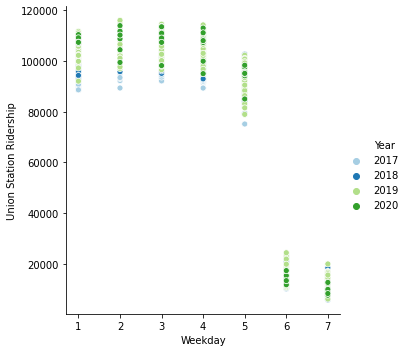

In [341]:
sns.relplot(x='Weekday',y='Union Station Ridership', data=data,hue='Year',palette='Paired')

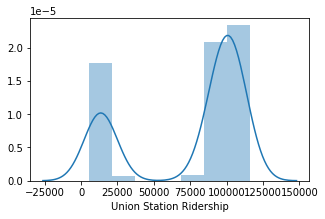

In [342]:
plt.figure(figsize=(5,3))
plt.tight_layout()
sns.distplot(data['Union Station Ridership'])

In [0]:
# Now let's divide the data into attributes ('Weekday') and labels ('Union Station Riderships').

X=data['Weekday'].values.reshape(-1,1)
y=data['Union Station Ridership'].values.reshape(-1,1)

In [0]:
#Split the data to 20% of the data to test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [345]:
# Train the algorithm

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [346]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[141774.68776727]
[[-16544.87902787]]


In [0]:
y_pred = regressor.predict(X_test)

In [348]:
# Let's use our test data and see how accurately our algorithm predicts the percentage score.

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}).round()
df

,Actual,Predicted
0,107492,108685.0
1,100565,75595.0
2,96529,108685.0
3,95809,108685.0
4,108883,108685.0
...,...,...
194,98263,75595.0
195,98114,108685.0
196,98723,59050.0
197,101471,75595.0


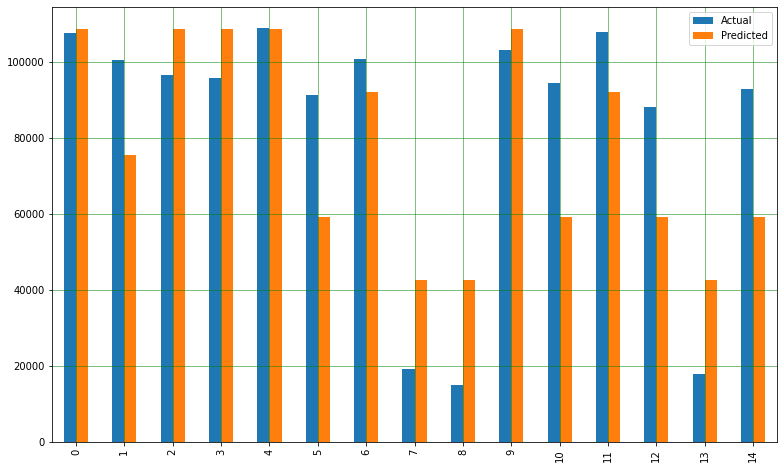

In [349]:
# Let's plot our results 


df1 = df.head(15)
df1.plot(kind='bar',figsize=(13,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Our initial thought was that by removing the outliers and expanding the data frame to cover the whole year would lead to a more precise predictive model.
After running the analysis, the model studied in part 2 seems more accurate.

## Multiple Linear Regression with 2 Variables

In [0]:
df = pd.read_csv(url,index_col='Date', parse_dates=True)

In [351]:
# Let's convert weekdays into integers

weekday = {'Monday':1 , 'Tuesday':2 , 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
df.Weekday = [weekday[item] for item in df.Weekday]
df.head()

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,3,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
2017-03-02,2017,3,2017-03,2,4,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2017-03-03,2017,3,2017-03,3,5,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
2017-03-04,2017,3,2017-03,4,6,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
2017-03-05,2017,3,2017-03,5,7,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488


In [0]:
# Build linear regression model using Weekday and Precipitation as predictors
# Split data into predictors X and output Y

predictors = ['Weekday','Total Precip (mm)']
X= df[predictors]
y=df['Union Station Ridership'].values.reshape(-1,1)

In [0]:
# Initialise and fit model
lm = LinearRegression()
model = lm.fit(X, y)

Instead of calulcating the values for alpha and betas, we have to call .intercept for alpha, and .coef_ for an array with our coefficients.



In [354]:
print(f'alpha = {model.intercept_}')
print(f'betas = {model.coef_}')

alpha = [130407.35411283]
betas = [[-14521.08711066   -117.60454459]]


We can predict the values by using .predict()

In [355]:
y_pred = model.predict(X)
y_pred

array([[84680.16916041],
       [72299.48476126],
       [57801.91855952],
       ...,
       [71958.43158196],
       [57672.55356047],
       [43139.70599535]])

In [356]:
new_X = [[7, 0.2]]
print(model.predict(new_X))

[[28736.22342928]]


Now that we have our predicting model, let's randomly pick a day and assess how far (or close) our model is from reality.

In [357]:
df[['Weekday','Total Precip (mm)','Union Station Ridership']].tail(15)

,Weekday,Total Precip (mm),Union Station Ridership
Date,,,
2020-02-15,6,0.4,15296
2020-02-16,7,0.4,12262
2020-02-17,1,1.0,11370
2020-02-18,2,8.6,104432
2020-02-19,3,0.0,107351
2020-02-20,4,1.0,108033
2020-02-21,5,0.2,94914
2020-02-22,6,0.2,17267
2020-02-23,7,0.8,12615


In [358]:
# Let's look at the 18th of February
prediction_1 = [[2, 8.6]]
print(model.predict(prediction_1))

[[100353.78080804]]


The model predicted 742,228 riderships while the actual number was 773,600: the prediction was pretty close.

In [359]:
# Let's look at the 26th of February 2020
prediction_2 = [[3, 11.8]]
print(model.predict(prediction_2))

[[85456.35915469]]


The model predicted 631,344 riderships while the actual number was 727,372. The prediction here was not as accurate.

## Linear Regression for Weekend Ridership Predicted by Temperature

In [360]:
# Importing the dataset and setting the date as index
data = pd.read_csv('https://raw.githubusercontent.com/Jenarth/SCS3250-Group-2-Final-Project/master/Final%20Dataset.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25,2020,2,2020-02,25,Tuesday,False,5.6,1.7,3.7,-1.906897,5.606897,0.2,2.137931,-1.937931,0.0,13650,15097,29727,36973,17192,6865,10485,99431,229420,False,226142.086667,260553.155725,191731.017608
2020-02-26,2020,2,2020-02,26,Wednesday,False,4.1,-3.2,0.4,-1.906897,2.306897,11.8,2.137931,9.662069,0.0,12596,13557,26690,33732,14331,6215,9749,98193,215063,False,227296.503311,254365.810172,200227.196451
2020-02-27,2020,2,2020-02,27,Thursday,False,-2.7,-5.3,-4.0,-1.906897,-2.093103,3.1,2.137931,0.962069,0.0,11349,13074,26818,34180,15281,5522,9151,94998,210373,False,224966.615894,253295.696280,196637.535508


**Looking at weekday ridership**

By analyzing the data, it is clear that ridership varies depending on whether the day is a weekday or weekend. First, the weekday data will be looked at. The weekday data is split from the main dataset here.



In [361]:
# Splitting data by day and concating the weekdays together
monday_data = data.loc[data['Weekday'] == 'Monday']
tuesday_data = data.loc[data['Weekday'] == 'Tuesday']
wednesday_data = data.loc[data['Weekday'] == 'Wednesday']
thursday_data = data.loc[data['Weekday'] == 'Thursday']
friday_data = data.loc[data['Weekday'] == 'Friday']
weekday_data= pd.concat([monday_data, tuesday_data, wednesday_data, thursday_data, friday_data])
weekday_data = weekday_data.sort_values(by='Date' ,ascending=True)
weekday_data

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-01,2017,3,2017-03,1,Wednesday,False,13.1,-1.9,5.6,-0.251613,5.851613,18.4,2.335484,16.064516,0.0,10022,13585,25273,32909,15599,5639,8804,95802,207633,False,227296.503311,254365.810172,200227.196451
2017-03-02,2017,3,2017-03,2,Thursday,False,-1.3,-6.4,-3.9,-0.251613,-3.648387,0.2,2.335484,-2.135484,0.5,9932,13331,26120,33884,15653,5665,8736,95873,209194,False,224966.615894,253295.696280,196637.535508
2017-03-03,2017,3,2017-03,3,Friday,False,-4.3,-8.1,-6.2,-0.251613,-5.948387,0.0,2.335484,-2.335484,0.5,8905,12235,23801,31473,14092,5129,7918,87200,190753,False,204211.905405,232457.905320,175965.905490
2017-03-06,2017,3,2017-03,6,Monday,False,4.9,-0.9,-9.8,-0.251613,-9.548387,0.0,2.335484,-2.335484,0.0,10154,13622,24393,31993,15964,5787,8740,94530,205183,False,219741.340909,261398.518741,178084.163077
2017-03-07,2017,3,2017-03,7,Tuesday,False,10.9,6.4,8.7,-0.251613,8.951613,9.6,2.335484,7.264516,0.0,10200,13754,25540,33525,16051,5738,8777,95390,208975,False,226142.086667,260553.155725,191731.017608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,2020,2,2020-02,24,Monday,False,9.4,2.2,5.8,-1.906897,7.706897,1.1,2.137931,-1.037931,0.0,13376,15108,29214,36460,17446,6869,10305,107350,236128,False,219741.340909,261398.518741,178084.163077
2020-02-25,2020,2,2020-02,25,Tuesday,False,5.6,1.7,3.7,-1.906897,5.606897,0.2,2.137931,-1.937931,0.0,13650,15097,29727,36973,17192,6865,10485,99431,229420,False,226142.086667,260553.155725,191731.017608
2020-02-26,2020,2,2020-02,26,Wednesday,False,4.1,-3.2,0.4,-1.906897,2.306897,11.8,2.137931,9.662069,0.0,12596,13557,26690,33732,14331,6215,9749,98193,215063,False,227296.503311,254365.810172,200227.196451


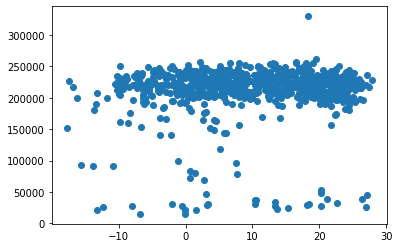

In [362]:
# Plotting weekday mean temperature with GO ridership
plt.scatter(weekday_data['Mean Temp (°C)'], weekday_data['Total GO Ridership'])

By looking at the weekday data above, there is no clear correlation between Weekday ridership (across all GO lines) and weekday temperature. Due to this, it doesn't make much sense to create a machine learning model to predict ridership on weekdays using temperature.

**Looking at weekend ridership**

First the weekend data needs to be split from the dataset.



In [363]:
# Splitting data by day and concating the weekend days together
saturday_data = data.loc[data['Weekday'] == 'Saturday']
sunday_data = data.loc[data['Weekday'] == 'Sunday']
weekend_data= pd.concat([saturday_data, sunday_data])
weekend_data = weekend_data.sort_values(by='Date' ,ascending=True)
weekend_data

,Year,Month,year_month,Day,Weekday,Holiday,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Monthly Mean Temp (°C),Delta Temp (°C),Total Precip (mm),Monthly Mean Precip (mm),Delta Precip (mm),Snow on Grnd (cm),Barrie Ridership,Kitchener Ridership,Lakeshore East Ridership,Lakeshore West Ridership,Milton Ridership,Richmond Hill Ridership,Stouffville Ridership,Union Station Ridership,Total GO Ridership,Outlier,Overall Mean,2SD_above,2SD_below
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-04,2017,3,2017-03,4,Saturday,False,-6.5,-11.9,-9.2,-0.251613,-8.948387,0.2,2.335484,-2.135484,0.5,928,480,7872,11756,208,0,246,13899,35389,False,45352.333333,73886.656469,16818.010198
2017-03-05,2017,3,2017-03,5,Sunday,False,-0.4,-10.6,-5.5,-0.251613,-5.248387,0.0,2.335484,-2.335484,0.5,803,398,4714,8381,169,0,156,8505,23126,False,32455.370861,53039.519234,11871.222488
2017-03-11,2017,3,2017-03,11,Saturday,False,-5.3,-12.5,-8.9,-0.251613,-8.648387,0.2,2.335484,-2.135484,0.5,877,463,6397,11193,174,0,199,10584,29887,False,45352.333333,73886.656469,16818.010198
2017-03-12,2017,3,2017-03,12,Sunday,False,-3.8,-12.5,-8.2,-0.251613,-7.948387,0.0,2.335484,-2.335484,0.5,756,345,4031,6915,97,2,102,6721,18969,False,32455.370861,53039.519234,11871.222488
2017-03-18,2017,3,2017-03,18,Saturday,False,3.1,0.1,1.6,-0.251613,1.851613,1.5,2.335484,-0.835484,0.0,1187,632,8199,13669,210,0,276,15697,39870,False,45352.333333,73886.656469,16818.010198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-15,2020,2,2020-02,15,Saturday,False,1.1,-8.7,-3.8,-1.906897,-1.893103,0.4,2.137931,-1.737931,0.0,1535,259,8070,11895,98,0,1014,15296,38167,False,45352.333333,73886.656469,16818.010198
2020-02-16,2020,2,2020-02,16,Sunday,False,4.3,-1.5,1.4,-1.906897,3.306897,0.4,2.137931,-1.737931,0.0,1501,169,6133,9534,73,0,795,12262,30467,False,32455.370861,53039.519234,11871.222488
2020-02-22,2020,2,2020-02,22,Saturday,False,5.5,-3.2,1.1,-1.906897,3.006897,0.2,2.137931,-1.937931,0.0,2323,271,9654,15429,121,0,1181,17267,46246,False,45352.333333,73886.656469,16818.010198


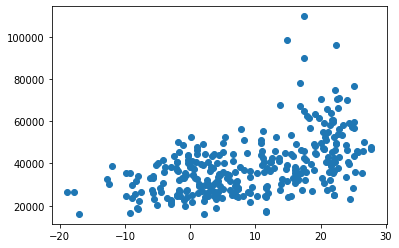

In [364]:
# Plotting weekday mean temperature with GO ridership
plt.scatter(weekend_data['Mean Temp (°C)'], weekend_data['Total GO Ridership'])

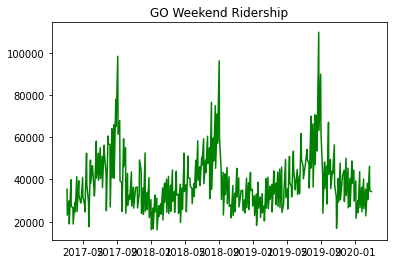

In [365]:
# Plotting Total GO Ridership on weekends over 3 years
plt.plot(weekend_data.index, weekend_data['Total GO Ridership'], color='green')
plt.title('GO Weekend Ridership')
plt.show()

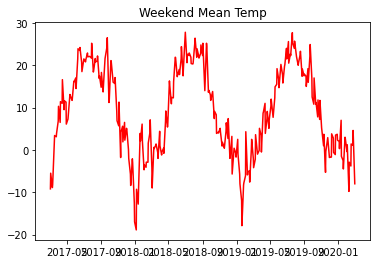

In [366]:
# Plotting mean temperature on weekends over 3 years
plt.plot(weekend_data.index, weekend_data['Mean Temp (°C)'], color='red')
plt.title('Weekend Mean Temp')
plt.show()

Here it is clear that there is a positive correlation between the weekend temperature and GO ridership (across all GO lines). It makes sense to attempt to build a machine learning model to predict the GO ridership (across all lines) for a given temperature.

**Building a Linear Regression Model for Weekend GO Ridership**

For the linear regression model, Total GO Ridership and Mean Temperature will be used.



In [367]:
#Using linear regression to fit a model and printing the coefficient and intercept
Y = weekend_data['Total GO Ridership']
X = weekend_data['Mean Temp (°C)'].values.reshape(-1, 1)

weekend_model = sklearn.linear_model.LinearRegression().fit(X,Y)
print(weekend_model.coef_)
print(weekend_model.intercept_)

[671.86679794]
32640.777367924864


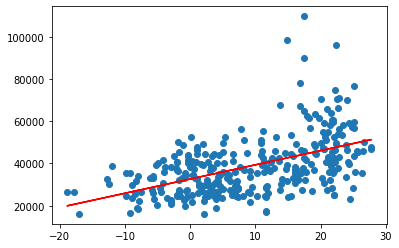

In [368]:
# Plotting Mean Temp (°C), Total GO Ridership, and the model
weekend_predict = weekend_model.predict(X)
plt.scatter(x=weekend_data['Mean Temp (°C)'], y=weekend_data['Total GO Ridership'])
plt.plot(X, weekend_predict, 'r-')
plt.show()

Above, the red line represents the best fit produced by the model. The model can be used to predict the GO ridership (across all lines) for any given temperature.



In [369]:
print(weekend_model.predict([[-5],[5],[15],[25]]))

[29281.44337823 36000.11135762 42718.77933702 49437.44731641]


Predicting the GO ridership for a tempreature of -5°C gives us a ridership of 29281. Similiarly for: 5°C = 36000, 15°C = 42718, 25°C = 49437.

In [370]:
# Calculating Root Mean Square Error
mse = mean_squared_error(Y, weekend_predict)
rmse = np.sqrt(mse)
print(rmse)

12055.52441187086


The Root Mean Square Error(RMSE) here is 12055. The best fit should have the lowest possible value for RMSE. Looking at the data, 12055 is fairly low for a data that has range from 0 to 120000. This is a fairly good model!